<a href="https://colab.research.google.com/github/Tonge-Shim/pytorchstudy/blob/main/chap6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#torch.nn
accepts 3 arguments:
> number of input features

> number of output features

> whether the linear model includes a bias or not(defaultinge to True)

In [11]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
torch.set_printoptions(edgeitems=2, linewidth=75)


we reshape out B inputs to B*Nin, where Nin is 1 and this is easily done with unsqueeze.

In [12]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [13]:

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([8, 1, 2, 6, 9, 7, 0, 4, 3]), tensor([10,  5]))

In [14]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [4]:
import torch.nn as nn

In [15]:
linear_model = nn.Linear(1,1)
linear_model(t_un_val)

tensor([[0.8293],
        [0.4661]], grad_fn=<AddmmBackward>)

In [17]:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[0.1863]], requires_grad=True)
Parameter containing:
tensor([-0.4448], requires_grad=True)


In [19]:
x = torch.ones(1)
linear_model(x)

tensor([-0.2585], grad_fn=<AddBackward0>)

#Batching Inputs
> any module in nn is written to produce outputs for a batch of multiple inputs at eh same time.

In [20]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.2585],
        [-0.2585],
        [-0.2585],
        [-0.2585],
        [-0.2585],
        [-0.2585],
        [-0.2585],
        [-0.2585],
        [-0.2585],
        [-0.2585]], grad_fn=<AddmmBackward>)

pass the linear model parameters to the optimizer using `paramters` method

In [33]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), # this method call replaces [params]
                      lr = 1e-2)

In [29]:
linear_model.parameters()

<generator object Module.parameters at 0x7f8a79eabdd0>

In [30]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.6391]], requires_grad=True), Parameter containing:
 tensor([0.8868], requires_grad=True)]

#change
> it hasn't changed practically at all, except that now we don't pass `params` explicitly to `model` since the model itself holds its Parameters internally.

In [31]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"f"Validation loss {loss_val.item():.4f}")

In [34]:
print(linear_model.weight)
print(linear_model.bias)
print()
training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train, 
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)
print()
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[0.3463]], requires_grad=True)
Parameter containing:
tensor([0.2442], requires_grad=True)

Epoch 1, Training loss 128.8181,Validation loss 187.4153
Epoch 1000, Training loss 3.7775,Validation loss 3.7068
Epoch 2000, Training loss 3.1665,Validation loss 2.3533
Epoch 3000, Training loss 3.1539,Validation loss 2.1840

Parameter containing:
tensor([[5.2394]], requires_grad=True)
Parameter containing:
tensor([-16.7264], requires_grad=True)


#replacing our linear model with a neural network as our approximating function
> `nn` provides a simple way to concatenate modules through the `nn.Sequential` container

In [35]:
seq_model = nn.Sequential(
    nn.Linear(1,13),#13 hidden features
    nn.Tanh(),
    nn.Linear(13,1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

calling model.parameters() will collect weight and bias from both the first and second linear modules. 

In [36]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

`named_parameters`

In [37]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Sequential also accepts an `OrderedDict`, in which we can name each module passed to Sequential

In [53]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
                                       ('hidden_linear', nn.Linear(1,8)),
                                       ('hidden_activation', nn.Tanh()),
                                       ('output_linear', nn.Linear(8,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [54]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [55]:
#access a particular parameter
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0408], requires_grad=True)

In [56]:
optimizer = optim.SGD(seq_model.parameters(), lr = 1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 166.5052,Validation loss 242.8537
Epoch 1000, Training loss 7.1406,Validation loss 4.3493
Epoch 2000, Training loss 5.3028,Validation loss 1.2474
Epoch 3000, Training loss 3.0931,Validation loss 0.2631
Epoch 4000, Training loss 2.4078,Validation loss 0.0576
Epoch 5000, Training loss 2.2117,Validation loss 0.0504
output tensor([[20.4123],
        [ 7.3119]], grad_fn=<AddmmBackward>)
answer tensor([[21.],
        [ 8.]])
hidden tensor([[-0.2713],
        [-0.2234],
        [ 6.7169],
        [ 6.3411],
        [ 6.2781],
        [ 0.1084],
        [ 0.2873],
        [ 6.6093]])


evaluate the model on all of the data and see how it differs from a line

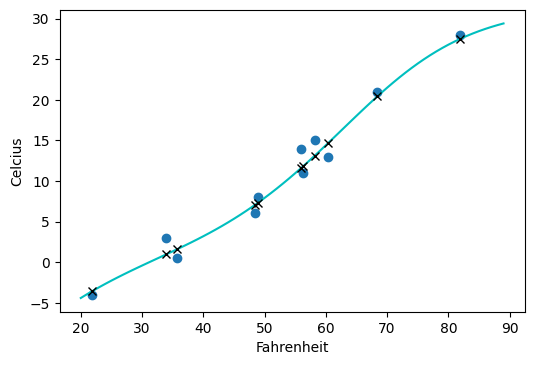

In [57]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi = 100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celcius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

the neural network has a tendency to overfit, seince it tries to chase the measurements, including the noisy ones.

#Exercise

In [58]:
import csv

In [60]:
wine_path = "/content/drive/MyDrive/DLWP/p1ch4/tabular-wine/winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype = np.float32, delimiter = ';', skiprows = 1)
wineq_numpy


array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [61]:
col_list = next(csv.reader(open(wine_path), delimiter = ';'))
wineq_numpy.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

In [62]:
wineq = torch.from_numpy(wineq_numpy)
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

In [63]:
data = wineq[:, :-1]
data, data.shape

(tensor([[ 7.0000,  0.2700,  ...,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  ...,  0.4900,  9.5000],
         ...,
         [ 5.5000,  0.2900,  ...,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  ...,  0.3200, 11.8000]]), torch.Size([4898, 11]))

In [77]:
target = wineq[:, -1]
target, target.shape

target

tensor([6., 6.,  ..., 7., 6.])

In [78]:
t_u = target.unsqueeze(1)
t_u

tensor([[6.],
        [6.],
        ...,
        [7.],
        [6.]])

In [79]:
data_mean = torch.mean(data, dim = 0)
data_var = torch.var(data, dim = 0)
data_n = (data-data_mean)/torch.sqrt(data_var)#normalize
data_n

tensor([[ 1.7208e-01, -8.1761e-02,  ..., -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  ...,  1.3422e-03, -8.2419e-01],
        ...,
        [-1.6054e+00,  1.1666e-01,  ..., -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  ..., -1.4882e+00,  1.0448e+00]])

In [80]:

n_samples = data_n.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices.shape, val_indices.shape


(torch.Size([3919]), torch.Size([979]))

In [81]:
t_un_train = data_n[train_indices]#input
t_c_train = t_u[train_indices]#label

t_un_val = data_n[val_indices]
t_c_val = t_u[val_indices]


In [83]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
                                       ('hidden_linear', nn.Linear(11,20)),
                                       ('hidden_activation', nn.Tanh()),
                                       ('output_linear', nn.Linear(20,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=11, out_features=20, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.SGD(seq_model.parameters(), lr = 1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

In [ ]:
#visualize...? 글쎄..?